In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import sys
%matplotlib inline

In [3]:
# # Arrays to store object points and image points from all the images.
# objpoints = [] # 3d points in real world space
# imgpoints = [] # 2d points in image plane.

# #prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# objp = np.zeros((6*9,3), np.float32)
# objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
img = cv2.imread('camera_cal/calibration1.jpg')
img_shape = img.shape
print(img_shape[:2])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
images = glob.glob('camera_cal/calibration*.jpg')
print(images[1])

(720, 1280)
(720, 1280)
camera_cal/calibration6.jpg


In [4]:
ret, mtx, dist, rvects, tvects = None, None, None, None, None

def calibrate_camera(path, imgshape):
    images = glob.glob(path)

    cb_shape = (9, 6)  # Corners we expect to be detected on the chessboard

    objpoints = []  # 3D points in real-world space
    imgpoints = []  # 2D points in the image

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)

        obj_p = np.zeros((cb_shape[0]*cb_shape[1], 3), np.float32)
        coords = np.mgrid[0:cb_shape[0], 0:cb_shape[1]].T.reshape(-1, 2)  # x, y coords

        obj_p[:,:2] = coords

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        status, corners = cv2.findChessboardCorners(gray, cb_shape, None)
        if status:
            objpoints.append(obj_p)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, cb_shape, corners, status)
        else:
            print("Couldn't find all corners in image:", fname)
    
    return cv2.calibrateCamera(objpoints, imgpoints, imgshape, None, None)

img = mpimg.imread('camera_cal/calibration11.jpg')
image_shape = img.shape
    
ret, mtx, dist, rvects, tvects = calibrate_camera('camera_cal/calibration*.jpg', image_shape[:2])
print(ret, mtx)
print(dist)


Couldn't find all corners in image: camera_cal/calibration1.jpg
Couldn't find all corners in image: camera_cal/calibration4.jpg
Couldn't find all corners in image: camera_cal/calibration5.jpg
1.1868973603151152 [[  1.15396100e+03   0.00000000e+00   6.69706490e+02]
 [  0.00000000e+00   1.14802504e+03   3.85655584e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.41018756e-01  -5.30666106e-02  -1.15811356e-03  -1.28285248e-04
    2.67027151e-02]]


In [5]:
def side_by_side_plot(im1, im2, im1_title=None, im2_title=None, im1_gray=False, im2_gray=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    if im1_gray:
        ax1.imshow(im1, cmap="gray")
    else:
        ax1.imshow(im1)
        
    if im1_title: ax1.set_title(im1_title, fontsize=30)
    if im2_gray:
        ax2.imshow(im2, cmap="gray")
    else:
        ax2.imshow(im2)
        
    if im2_title: ax2.set_title(im2_title, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

def big_plot(img):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(img)

In [6]:
# Undistort a image
def undistort(img, mtx, dist):
    try:
        undist = cv2.undistort(img, mtx, dist, None, mtx)
    except Exception as e:
        print(e)
        sys.exit(1)
    return undist

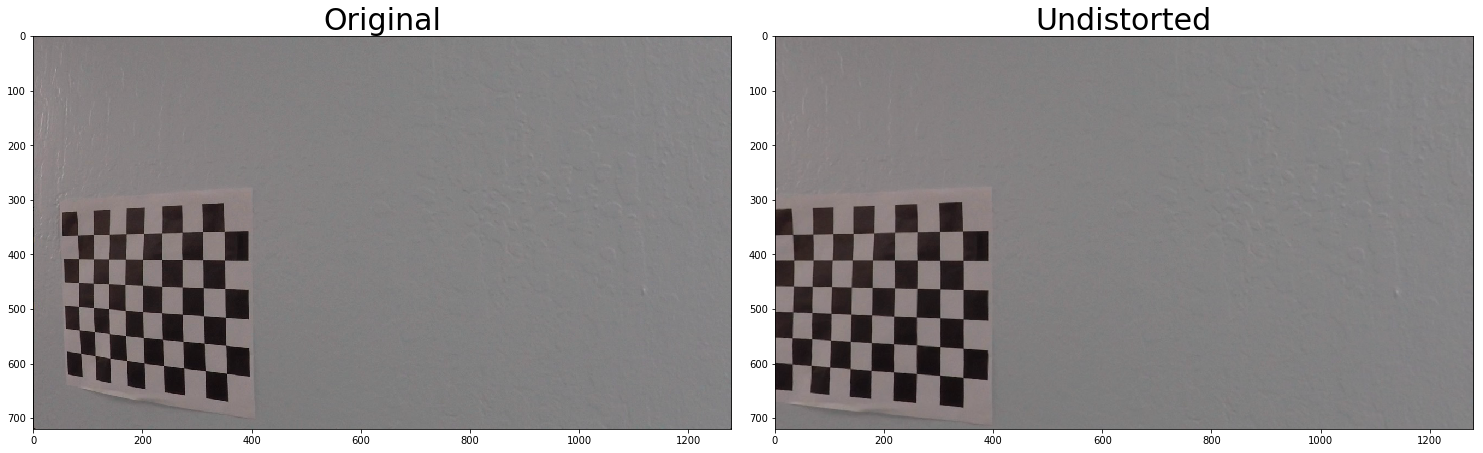

In [7]:
# validate the undistortion
img = cv2.imread('camera_cal/calibration20.jpg')
undistorted = undistort(img, mtx, dist)
#cv2.imwrite('./example_images/undistorted_checkerboard.jpg', undistorted)
side_by_side_plot(img, undistorted, 'Original', 'Undistorted')

In [8]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, kernel=5):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == "x":
        xdir, ydir = 1, 0
    else:
        xdir, ydir = 0, 1
    sobel = cv2.Sobel(gray, cv2.CV_64F, xdir, ydir, ksize=kernel)
    # 3) Take the absolute value of the derivative or gradient
    sobel_abs = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_factor = np.max(sobel_abs)/255 
    scaled_sobel = (sobel_abs/scale_factor).astype(np.uint8) 
#     scaled_sobel = np.uint8(255*sobel_abs/np.max(sobel_abs))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    # binary_output = np.copy(img) # Remove this line
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hsl_threshold(img, select, thresh=(0, 255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)   # ??? RGB or BGR 
    if select == "s":
        channel = hls[:,:,2]
    elif select == "l":
        channel = hls[:,:,1]
    else:
        channel = hls[:,:,0]
        
    # Threshold color channel
    thresh_min = thresh[0] #170
    thresh_max = thresh[1] #255
    binary = np.zeros_like(channel)
    binary[(channel >= thresh_min) & (channel <= thresh_max)] = 1
    
    return binary

def rg_threshold(img, select, thresh=(200, 255)):
#     print(img.shape)
    if select == "r":
        channel = img[:,:,0]
    elif select == "g":
        channel = img[:,:,1]
    else:
        channel = img[:,:,2]
    # Threshold color channel
    thresh_min = thresh[0] #170
    thresh_max = thresh[1] #255
    binary = np.zeros_like(channel)
    binary[(channel >= thresh_min) & (channel <= thresh_max)] = 1
    
    return binary

def apply_thresholds_v2(undistorted_image, draw=False):
    grad_binary_x = abs_sobel_thresh(undistorted_image, orient='x', thresh_min=10, thresh_max=200)
#     side_by_side_plot(undistorted_image, grad_binary_x, 'undistorted_image ' + fname, 'Grad x')
    grad_dir = dir_threshold(undistorted_image, sobel_kernel=15, thresh=(np.pi/6, np.pi/2))
#     side_by_side_plot(undistorted_image, grad_dir, 'undistorted_image ' + fname, 'Grad dir')
    combined_condition = np.zeros_like(grad_binary_x)
    combined_condition [(grad_binary_x == 1) & (grad_dir == 1)] = 1
#     side_by_side_plot(undistorted_image, combined_condition, 'undistorted_image ' + fname, 'combined_condition')
    sm_image = hsl_threshold(undistorted_image, "s", (100, 255))
#     side_by_side_plot(undistorted_image, sm_image, 'undistorted_image ' + fname, 'S threshold')
    l_thresh = (120, 255)
    lm_image = hsl_threshold(undistorted_image, "l", (120, 255))
#     side_by_side_plot(undistorted_image, lm_image, 'undistorted_image ' + fname, 'lm threshold')
    r_image = rg_threshold(undistorted_image, "r", (150, 255))
#     side_by_side_plot(undistorted_image, r_image, 'undistorted_image ' + fname, 'R threshold for white')
    g_image = rg_threshold(undistorted_image, "g", (150, 255))
#     side_by_side_plot(undistorted_image, g_image, 'undistorted_image ' + fname, 'G threshold for white')
    r_g_condition = (r_image & g_image)
#     side_by_side_plot(undistorted_image, r_g_condition, 'undistorted_image ' + fname, 'r_g_condition')
    color_combined1 = np.zeros_like(grad_binary_x)
    color_combined1 [(sm_image == 1) | (combined_condition == 1)] = 1
#     side_by_side_plot(undistorted_image, color_combined1, 'undistorted_image ' + fname, 'color_combined1')
    color_combined2 = np.zeros_like(grad_binary_x)
    color_combined2 [(lm_image == 1) & (r_g_condition == 1)] = 1
#     side_by_side_plot(undistorted_image, color_combined2, 'undistorted_image ' + fname, 'color_combined2')
    color_combined3 = np.zeros_like(grad_binary_x)
    color_combined3 [(color_combined1 == 1) & (color_combined2 == 1)] = 1
#     side_by_side_plot(undistorted_image, color_combined3, 'undistorted_image ' + fname, 'color_combined3')
    
    if draw:
        side_by_side_plot(undistorted_image, grad_binary_x, 'undistorted_image ' + fname, 'Grad x')

        side_by_side_plot(undistorted_image, grad_dir, 'undistorted_image ' + fname, 'Grad dir')

        side_by_side_plot(undistorted_image, combined_condition, 'undistorted_image ' + fname, 'combined_condition')

        side_by_side_plot(undistorted_image, sm_image, 'undistorted_image ' + fname, 'S threshold')

        side_by_side_plot(undistorted_image, lm_image, 'undistorted_image ' + fname, 'lm threshold')

        side_by_side_plot(undistorted_image, r_image, 'undistorted_image ' + fname, 'R threshold for white')

        side_by_side_plot(undistorted_image, g_image, 'undistorted_image ' + fname, 'G threshold for white')

        side_by_side_plot(undistorted_image, r_g_condition, 'undistorted_image ' + fname, 'r_g_condition')

        side_by_side_plot(undistorted_image, color_combined1, 'undistorted_image ' + fname, 'color_combined1')

        side_by_side_plot(undistorted_image, color_combined2, 'undistorted_image ' + fname, 'color_combined2')

        side_by_side_plot(undistorted_image, color_combined3, 'undistorted_image ' + fname, 'color_combined3')

    
    return color_combined3


def apply_thresholds_v1(image, show=True):
#     img, M = birds_eye(image, display = False)
    img = image

    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

#     if show == True:
#         # Plotting thresholded images
#         f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
#         f.tight_layout()
        
#         ax1.set_title('Original Image', fontsize=16)
#         ax1.imshow(image)
        
#         ax2.set_title('Warped Image', fontsize=16)
#         ax2.imshow(img)
        
#         ax3.set_title('s binary threshold', fontsize=16)
#         ax3.imshow(s_binary, cmap='gray')
        
#         ax4.set_title('b binary threshold', fontsize=16)
#         ax4.imshow(b_binary, cmap='gray')
        
#         ax5.set_title('l binary threshold', fontsize=16)
#         ax5.imshow(l_binary, cmap='gray')

#         ax6.set_title('Combined color thresholds', fontsize=16)
#         ax6.imshow(combined_binary, cmap='gray')
        
        
#     else: 
    return combined_binary

In [9]:
class placeholder(object):
    def __init__(self, M, Minv, mtx, dist, leftx, lefty, rightx, righty, leftcm, rightcm, left_fitx, right_fitx):
        """Return a Customer object whose name is *name* and starting
        balance is *balance*."""
        self.M = M         # warp matrix
        self.Minv = Minv   # unwarp matrix
        self.mtx = mtx     # camera calibration mtx
        self.dist = dist   # came calibration distortion
        self.prev_leftx = leftx
        self.prev_lefty = lefty
        self.prev_rightx = rightx
        self.prev_righty = righty
        self.prev_leftcm = leftcm  # left lane curvature
        self.prev_rightcm = rightcm # right lane curvature
        self.prev_left_fitx = left_fitx  # left lane curvature
        self.prev_right_fitx = right_fitx # right lane curvature
        



In [10]:
def findpeaks_v2(binary_warped, orig_img, draw=False):
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype(np.uint8)
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    if left_lane_inds is None:
        print("findpeaks_v2 left_lane_inds is None")
    right_lane_inds = np.concatenate(right_lane_inds)
    if left_lane_inds is None:
        print("findpeaks_v2 left_lane_inds is None")

    left_fitx, right_fitx = figure_out_line_predictions(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, binary_warped)
    
    return left_fitx, right_fitx
    
    
def figure_out_line_predictions(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, binary_warped):
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    # If no pixels were found return None
    if(leftx.size == 0 or lefty.size == 0):
        return None, None
    
    left_fit = np.polyfit(lefty, leftx, 2)
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    if(rightx.size == 0 or righty.size == 0):
        return None, None
    
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx

def measure_radius_of_curvature(x_values, num_rows):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    ploty = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

def pipeline_v2(image, draw=False):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    if draw:
        fig = plt.figure(figsize=(60, 60))
    
    imshape = image.shape
    undistorted_image = undistort(image, placeme.mtx, placeme.dist)
    if draw:
        a = fig.add_subplot(7, 2, 1)
        a.set_title('original image', fontsize = 40)
        plt.imshow(image)
    if draw:
        a = fig.add_subplot(7, 2, 2)
        a.set_title('undistorted image', fontsize = 40)
        plt.imshow(undistorted_image)
    
    rglsx_binary = apply_thresholds_v2(undistorted_image)
    if draw:
        a = fig.add_subplot(7, 2, 3)
        a.set_title('rglsx_binary', fontsize = 40)
        plt.imshow(rglsx_binary)
        
    # get region of interest
    vertices = np.array([[(0, imshape[0]), (550, 470), (730, 470), (1280,imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(rglsx_binary, vertices)
    if draw:
        a = fig.add_subplot(7, 2, 4)
        a.set_title('masked with region of interest', fontsize = 40)
        plt.imshow(masked_image)
        
    if placeme.M is None and placeme.Minv is None:
        src, dst = calculate_dst_for_perspective_transform(vertices, correction_factor=(40.0, -40.0, 40.0, -40.0))  #correction_factor=(-75.0, 20.0))
        M, Minv = calculate_perspective_matrix(src, dst)
        placeme.M = M
        placeme.Minv = Minv
    
    # warp it
    warped = cv2.warpPerspective(masked_image, placeme.M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    if draw:
        a = fig.add_subplot(7, 2, 5)
        a.set_title('warped image', fontsize = 40)
        plt.imshow(warped)
    warped_bin = np.zeros_like(warped[:,:])
    warped_bin[(warped[:,:] > 0)] = 1
    
    out_img = np.dstack((warped_bin, warped_bin, warped_bin))*255
    
    nonzero = warped_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    num_rows = warped_bin.shape[0]
    ploty = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        searchpeaks = True
        left_fitx, right_fitx = findpeaks_v2(warped_bin, image, draw)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        searchpeaks = False
        margin = 100
        left_fitx = polyfit_left[0]*nonzeroy**2 + polyfit_left[1]*nonzeroy + polyfit_left[2]
        left_lane_inds = ((nonzerox >= left_fitx - margin) & (nonzerox <= left_fitx + margin)).nonzero()[0]

        right_fitx = polyfit_right[0]*nonzeroy**2 + polyfit_right[1]*nonzeroy + polyfit_right[2]
        right_lane_inds = ((nonzerox >= right_fitx - margin) & (nonzerox <= right_fitx + margin)).nonzero()[0]
        
        left_fitx, right_fitx = figure_out_line_predictions(nonxerox, nonzeroy, left_lane_inds, right_lane_inds, binary_warped)
        
    if (left_fitx is None or right_fitx is None):
        if not searchpeaks:
            left_fitx, right_fitx = findpeaks_v2(warped_bin, image, draw)
            
    bad_lines = False
            
    if (left_fitx is None or right_fitx is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_fitx - left_fitx)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not searchpeaks:
                left_fitx, right_fitx = findpeaks_v2(warped_bin, image, draw)
                if (left_fitx is None or right_fitx is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_fitx - left_fitx)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return image
        else:
            left_fitx = past_good_left_lines[-1]
            right_fitx = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_fitx = get_averaged_line(past_good_left_lines, left_fitx)
        past_good_right_lines, right_fitx = get_averaged_line(past_good_right_lines, right_fitx)
        mean_difference = np.mean(right_fitx - left_fitx)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
        
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
#     left_curverad = ((1 + (2*left_fitx[0]*y_eval + left_fitx[1])**2)**1.5) / np.absolute(2*left_fitx[0])
#     right_curverad = ((1 + (2*right_fitx[0]*y_eval + right_fitx[1])**2)**1.5) / np.absolute(2*right_fitx[0])
#     print("left curvead right curvead in pixels: ", left_curverad, right_curverad)
    
#     # Define conversions in x and y from pixels space to meters
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    

#     # Fit new polynomials to x,y in world space
#     left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
#     right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
#     # Calculate the new radii of curvature
#     left_curveadm = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
#     right_curveadm = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # compute the radius of curvature
    left_curveadm = measure_radius_of_curvature(left_fitx, num_rows)
    right_curveadm = measure_radius_of_curvature(right_fitx, num_rows)
    average_curve_radm = (left_curveadm + right_curveadm)/2
    # Now our radius of curvature is in meters
    print(left_curveadm, 'm', right_curveadm, 'm', average_curve_radm, 'm')
    
    midpoint = np.int(image.shape[1]/2)
    middle_of_lane = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    offset = abs(midpoint - middle_of_lane) * xm_per_pix
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(out_img, placeme.Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, unwarp, 0.3, 0)
    
    cv2.putText(result,"Avg Radius of curvature: " + "{:0.2f}".format(average_curve_radm/1000) + 'km', org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"C. Position from center: " + "{:0.2f}".format(offset) + 'm', org=(50,150), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    
    if draw:
        a = fig.add_subplot(7, 2, 6)
        a.set_title('image with lanes traced', fontsize = 40)
        plt.imshow(result)
    
    if draw:
        plt.show()
    
    return result


def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line

def add_line(previous_lines, new_line):
    if new_line is not None:
        if len(previous_lines) >= 12:
            previous_lines.pop(0)
        previous_lines.append(new_line)
    
    return previous_lines
        
def pipeline_v3(image, draw=False):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    if draw:
        fig = plt.figure(figsize=(60, 60))
    
    imshape = image.shape
    undistorted_image = undistort(image, placeme.mtx, placeme.dist)
    if draw:
        a = fig.add_subplot(7, 2, 1)
        a.set_title('original image', fontsize = 40)
        plt.imshow(image)
    if draw:
        a = fig.add_subplot(7, 2, 2)
        a.set_title('undistorted image', fontsize = 40)
        plt.imshow(undistorted_image)  
        
    rglsx_binary = apply_thresholds_v2(undistorted_image)
    if draw:
        a = fig.add_subplot(7, 2, 3)
        a.set_title('rglsx_binary', fontsize = 40)
        plt.imshow(rglsx_binary)
        
    # get region of interest
    vertices = np.array([[(0, imshape[0]), (550, 470), (730, 470), (1280,imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(rglsx_binary, vertices)
    if draw:
        a = fig.add_subplot(7, 2, 4)
        a.set_title('masked with region of interest', fontsize = 40)
        plt.imshow(masked_image)
        
    if placeme.M is None and placeme.Minv is None:
        src, dst = calculate_dst_for_perspective_transform(vertices, correction_factor=(40.0, -40.0, 40.0, -40.0))  #correction_factor=(-75.0, 20.0))
        M, Minv = calculate_perspective_matrix(src, dst)
        placeme.M = M
        placeme.Minv = Minv
    
    # warp it
    warped = cv2.warpPerspective(masked_image, placeme.M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    if draw:
        a = fig.add_subplot(7, 2, 5)
        a.set_title('warped image', fontsize = 40)
        plt.imshow(warped)
    warped_bin = np.zeros_like(warped[:,:])
    warped_bin[(warped[:,:] > 0)] = 1
    
    out_img = np.dstack((warped_bin, warped_bin, warped_bin))*255
    
    nonzero = warped_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    num_rows = warped_bin.shape[0]
    ploty = np.linspace(0, num_rows-1, num_rows)

    left_fitx, right_fitx = findpeaks_v2(warped_bin, image, draw)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fitx[0]*y_eval + left_fitx[1])**2)**1.5) / np.absolute(2*left_fitx[0])
    right_curverad = ((1 + (2*right_fitx[0]*y_eval + right_fitx[1])**2)**1.5) / np.absolute(2*right_fitx[0])
    print("left curvead right curvead in pixels: ", left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curveadm = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curveadm = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # compute the radius of curvature
    left_curveadm = measure_radius_of_curvature(left_fitx, num_rows)
    right_curveadm = measure_radius_of_curvature(right_fitx, num_rows)
    average_curve_radm = (left_curveadm + right_curveadm)/2
    # Now our radius of curvature is in meters
    print(left_curveadm, 'm', right_curveadm, 'm', average_curve_radm, 'm')
    
    midpoint = np.int(image.shape[1]/2)
    middle_of_lane = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    offset = abs(midpoint - middle_of_lane) * xm_per_pix
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(out_img, placeme.Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, unwarp, 0.3, 0)
    
    cv2.putText(result,"Avg Radius of curvature: " + "{:0.2f}".format(average_curve_radm/1000) + 'km', org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"C. Position from center: " + "{:0.2f}".format(offset) + 'm', org=(50,150), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    
    if draw:
        a = fig.add_subplot(7, 2, 6)
        a.set_title('image with lanes traced', fontsize = 40)
        plt.imshow(result)
    
    if draw:
        plt.show()
    
    return result
    
    
def pipeline_v4(image, draw=False):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    if draw:
        fig = plt.figure(figsize=(60, 60))
    
    imshape = image.shape
    undistorted_image = undistort(image, placeme.mtx, placeme.dist)
    if draw:
        a = fig.add_subplot(7, 2, 1)
        a.set_title('original image', fontsize = 40)
        plt.imshow(image)
    if draw:
        a = fig.add_subplot(7, 2, 2)
        a.set_title('undistorted image', fontsize = 40)
        plt.imshow(undistorted_image)  
        
    rglsx_binary = apply_thresholds_v2(undistorted_image)
    if draw:
        a = fig.add_subplot(7, 2, 3)
        a.set_title('rglsx_binary', fontsize = 40)
        plt.imshow(rglsx_binary)
        
    # get region of interest
    vertices = np.array([[(0, imshape[0]), (550, 470), (730, 470), (1280,imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(rglsx_binary, vertices)
    if draw:
        a = fig.add_subplot(7, 2, 4)
        a.set_title('masked with region of interest', fontsize = 40)
        plt.imshow(masked_image)
        
    if placeme.M is None and placeme.Minv is None:
        src, dst = calculate_dst_for_perspective_transform(vertices, correction_factor=(40.0, -40.0, 40.0, -40.0))  #correction_factor=(-75.0, 20.0))
        M, Minv = calculate_perspective_matrix(src, dst)
        placeme.M = M
        placeme.Minv = Minv
    
    # warp it
    warped = cv2.warpPerspective(masked_image, placeme.M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    if draw:
        a = fig.add_subplot(7, 2, 5)
        a.set_title('warped image', fontsize = 40)
        plt.imshow(warped)
    warped_bin = np.zeros_like(warped[:,:])
    warped_bin[(warped[:,:] > 0)] = 1
    
    out_img = np.dstack((warped_bin, warped_bin, warped_bin))*255
    
    nonzero = warped_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    num_rows = warped_bin.shape[0]
    ploty = np.linspace(0, num_rows-1, num_rows)

    left_fitx, right_fitx = findpeaks_v2(warped_bin, image, draw)
    
    mean_difference = np.mean(right_fitx - left_fitx)
    
    if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
            bad_lines = False
    else:    
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
        else:
            bad_lines = False
    
    if bad_lines:
        if len(past_good_left_lines) != 0 and len(past_good_right_lines) != 0:
            left_fitx = past_good_left_lines[-1]
            right_fitx = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_fitx = get_averaged_line(past_good_left_lines, left_fitx)
        past_good_right_lines, right_fitx = get_averaged_line(past_good_right_lines, right_fitx)
        add_line(past_good_left_lines,left_fitx)
        add_line(past_good_right_lines,right_fitx)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
        
    
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fitx[0]*y_eval + left_fitx[1])**2)**1.5) / np.absolute(2*left_fitx[0])
    right_curverad = ((1 + (2*right_fitx[0]*y_eval + right_fitx[1])**2)**1.5) / np.absolute(2*right_fitx[0])
#     print("left curvead right curvead in pixels: ", left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curveadm = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curveadm = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # compute the radius of curvature
    left_curveadm = measure_radius_of_curvature(left_fitx, num_rows)
    right_curveadm = measure_radius_of_curvature(right_fitx, num_rows)
    average_curve_radm = (left_curveadm + right_curveadm)/2
    # Now our radius of curvature is in meters
#     print(left_curveadm, 'm', right_curveadm, 'm', average_curve_radm, 'm')
    
    midpoint = np.int(image.shape[1]/2)
    middle_of_lane = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    offset = abs(midpoint - middle_of_lane) * xm_per_pix
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(out_img, placeme.Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, unwarp, 0.3, 0)
    
    cv2.putText(result,"Avg Radius of curvature: " + "{:0.2f}".format(average_curve_radm) + 'm', org=(100,90), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"C. Position from center: " + "{:0.2f}".format(offset) + 'm', org=(50,150), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    
    if draw:
        a = fig.add_subplot(7, 2, 6)
        a.set_title('image with lanes traced', fontsize = 40)
        plt.imshow(result)
    
    if draw:
        plt.show()
    
    return result
    
    
    

In [11]:
def findvertices(vertex_lower, vertex_upper):
    # find center point of line
    yl = vertex_lower[0,1]
    xl = vertex_lower[0,0]
#     print(xl, yl)

    yu = vertex_upper[0,1]
    xu = vertex_upper[0,0]
#     print(xu, yu)

    centerX = abs(xu - xl) / 2 + xl
    # centerY = abs(abs(yu - yl) / 2 - yl)
    # centerYfromtop = abs(abs(yu - yl)/2 + yu)

    # print(centerX, centerY, centerYfromtop)
    x_lower_left = centerX
    y_lower_left = yl

    x_upper_left = centerX
    y_upper_left = yu

#     print(x_lower_left, y_lower_left, x_upper_left, y_upper_left)
    
    return int(x_lower_left), int(y_lower_left), int(x_upper_left), int(y_upper_left)

def calculate_dst_for_perspective_transform(vertices, correction_factor=(0.0, 0.0, 0.0, 0.0)):
    # find src and dest points for perspective transform 
# for src use the points of roi trapezium
# for dest: find the center of each line in roi trapezium, then draw a perpendicular line trhough center tocuhing horizontal
# axes, that will be the lower co-ordinate for left side. For upper co-ordinate, take x axes of lower co-ordinate and y-axes o
# of the upper point on left side of roi ... do same thing for right side ... now we have the dst points
    left_vertex_lower = vertices[:,0,:]
    left_vertex_upper = vertices[:,1,:]
    right_vertex_upper = vertices[:,3,:]
    right_vertex_lower = vertices[:,2,:]
    
    src = np.squeeze(vertices, axis=0).astype('float32')
    
    lxl, lyl, lxu, lyu = findvertices(left_vertex_lower, left_vertex_upper)
    rxl, ryl, rxu, ryu = findvertices(right_vertex_lower, right_vertex_upper)
    
    
    # the correction factor can be made more dynamic by calculating the slope of the one of the
    # lines in the warped image and then if the slope is +ve/-ve , a +ve/-ve correction_factor 
    # can be increased in steps of 5.
    # but here im going with 35

    dst = np.float32(
        [[lxl - correction_factor[0] , lyl],
         [lxu - correction_factor[1] , 0],
         [rxl - correction_factor[2] , 0],
         [rxu - correction_factor[3] , ryu]])
    
    return src, dst
    

def calculate_perspective_matrix(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [ ]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

path="../test_images/straight*.jpg"
images = sorted(glob.glob(path))
placeme = placeholder(None, None, mtx, dist, None, None, None, None, None, None, None, None)
for idx, fname in enumerate(images):
    print("Target image is : ", fname)
    image = mpimg.imread(fname)
    result = pipeline_v3(image, draw=True)

In [ ]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

path="../test_images/test2.jpg"
images = sorted(glob.glob(path))
placeme = placeholder(None, None, mtx, dist, None, None, None, None, None, None, None, None)
for idx, fname in enumerate(images):
    print("Target image is : ", fname)
    image = mpimg.imread(fname)
    result = pipeline_v3(image, draw=True)

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

import imageio
imageio.plugins.ffmpeg.download()

placeme = placeholder(None, None, mtx, dist, None, None, None, None, None, None, None, None)

output = 'project_output_colour_pipeline_v4_5.mp4' 
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pipeline_v4)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output_colour_pipeline_v4_5.mp4
[MoviePy] Writing video project_output_colour_pipeline_v4_5.mp4


100%|█████████▉| 1260/1261 [05:55<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour_pipeline_v4_5.mp4 

CPU times: user 10min 15s, sys: 19.4 s, total: 10min 34s
Wall time: 5min 56s


In [ ]:
#### below this is all rough work ######

In [ ]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

import os

path="../test_images/input_frames/input*.jpg"
images = sorted(glob.glob(path))
placeme = placeholder(None, None, mtx, dist, None, None, None, None, None, None, None, None)
for idx, fname in enumerate(images):
    result = None
    print("Target image is : ", fname)
    parts = os.path.split(fname)
#     print(parts[-1])
    name = os.path.splitext(parts[-1])
#     print(name)
    index = name[0].replace('input','')
#     print(index)
    image = cv2.imread(fname)
    result = pipeline_v3(image, draw=False)
    cv2.imwrite("../test_images/output_frames/output" + index + ".jpg", result)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

import imageio
imageio.plugins.ffmpeg.download()

placeme = placeholder(None, None, mtx, dist, None, None, None, None, None, None, None, None)

output = 'project_output_colour_apply_threshold_v2_2.mp4'   # project_output_colour7.mp4 is good
clip1 = VideoFileClip("../project_video.mp4")
output_clip = clip1.fl_image(pipeline_v2) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)